# Comparison of two sleep classifiers with LOOX

In this notebook, we analyze the performance of logistic regression on _Walch et al._ and a modified form we call the "hybrid motion" data set. This data set was created by taking triaxial accelerometer sampled at 50 Hz and combining with the gyroscopic measurements from a Naval platform to capture ship rotational and vibrational noise. 

We further compare logistic regression with the deep UNet model, with best performing open weights, from _Mads Olsen et al._.

Our models output, for each 30 second epoch of input recordings (accelerometer, actigraphy, and/or heart rate and other features) a probability of a particular epoch of recording corresponding to a `sleep` PSG label. When running inference to group the epochs into periods of sleep and wake (or sleep stages), we set a threshold for this probability, above which we predict an epoch sleep. For example, if a model outputs `0.71` (probability of sleep) for a given epoch, then a threshold of `0.5` will send this prediction to `sleep` since `0.71 > 0.5`, whereas a more stringent threshold of `0.76` would return a prediction of `wake` since `0.71 <= 0.76`. 

An ROC curve captures this trade-off that comes with the threshold, and also captures the fact that it's not so important that the model has probabilities spanning 0 to 1; even if the model only outputs predictions between 0.7 and 0.8, we could still pick an optimal threshold between those values as the cut-off for `sleep` or `wake` differentiation.


The metrics we will use are:
1. **AUROC**: area under ROC. 

    This is a useful way to evaluate prediction power of a trained model in highly class-imbalanced data, such as our recordings which are mostly people asleep with brief awakenings at the beginning and end, and a few places in the middle, of the recording.
2. **WASA93**: Wake accuracy when sleep accuracy is at least 93%. 

    Recalling the trade-off between scoring each class accurately and not missing epochs, for WASA93 we choose a threshold makign sleep accuracy (total fraction scored correct) at least 0.93% and then evalute the wake epochs with that threshold. This score is one way of quantifying the reliability of the prediction, especially in high-risk scenarios where monitoring awakenings during schedule sleep hours is important.

3. **Cohen's kappa**: A classical statistic that quantifies the amount to which the labels predicted (at various thresholds) have "random" agreement with the true labels. For example, when a model simply outputs the same class (ie everything is reported as `sleep`, independent of input) the kappa returns the fraction of true labels that take on that class.

# Setup & Preprocessing

We will set up some variables we'll re-use a lot, as well as preprocess the acelerometer data into spectrograms and save that data, along with its labels, in a pickled iterator.

In [1]:
!pisces_setup

Using TensorFlow backend
Converting Mads Olsen model to Keras...
Model saved at /Users/eric/Engineering/Work/pisces/pisces/cached_models/mo_resunet.keras


In [2]:
import numpy as np
import tensorflow as tf
import pisces.models as pm
from matplotlib import pyplot as plt
from pisces.data_sets import DataSetObject, ModelInputSpectrogram, ModelOutputType, DataProcessor, PSGType

Using TensorFlow backend


## Set up paths for caching
Set up all the paths here, ensure the (sub)folders all exist so later when we try to save to these there are no errors.

In [3]:

import os
from pathlib import Path

CWD = Path(os.getcwd())
save_path = CWD.joinpath("pre_processed_data")
hybrid_path = save_path.joinpath("hybrid")
os.makedirs(hybrid_path, exist_ok=True)
walch_path = save_path.joinpath("walch")
os.makedirs(walch_path, exist_ok=True)
data_location = CWD.parent.joinpath('data_sets')#CWD.parent.joinpath("data_sets")

walch_preprocessed_path = walch_path.joinpath("walch_preprocessed_data.npy")
hybrid_preprocessed_path = hybrid_path.joinpath("hybrid_preprocessed_data.npy")


In [4]:
data_location

PosixPath('/Users/eric/Engineering/Work/pisces/data_sets')

In [9]:
def preprocess_if_needed(data_set, save_preprocessing_to, subjects_to_exclude):
    if save_preprocessing_to.exists():
        print(f"Preprocessed data found at {save_preprocessing_to}.\nSkipping pre-processing. Remove this file and re-run this notebook to trigger re-processing.")
        return
    else:
        sampling_hz = 32 # Hz
        input_features = ['accelerometer']
        model_input = ModelInputSpectrogram(input_features, sampling_hz)
        output_type = ModelOutputType.WAKE_LIGHT_DEEP_REM
        data_processor = DataProcessor(data_set, 
                                       model_input, 
                                       output_type=output_type,
                                       psg_type=PSGType.HAS_N4)
        mo = pm.MOResUNetPretrained(data_processor=data_processor, sampling_hz=sampling_hz)
        ids_to_preprocess = [id for id in data_set.ids if id not in subjects_to_exclude]
        preprocessed_data = [mo.get_needed_X_y(id, mo.data_processor) for id in ids_to_preprocess]
        # Prepare a bundle to save
        to_save = [
            (data, id)
            for (data, id) in zip(preprocessed_data, ids_to_preprocess)
            if data is not None
        ]
        print(f"Saving to {save_preprocessing_to}...")
        np.save(save_preprocessing_to,
                np.array(to_save, dtype=object)
                )

## Walch

In [10]:
sets = DataSetObject.find_data_sets(data_location)
walch = sets['walch_et_al']
walch.parse_data_sets()
print(f"Found {len(walch.ids)} subjects. (Should be 31)")

Found 31 subjects. (Should be 31)


In [11]:
subjects_to_exclude_walch = [
    "759667", "3509524", "7749105",
    "9961348", "5132496",
]

In [13]:
preprocess_if_needed(walch, walch_preprocessed_path, subjects_to_exclude_walch)

resampling to 32.0Hz (0.03125s) from 49 Hz (0.02001s)
resampling to 32.0Hz (0.03125s) from 49 Hz (0.02001s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01986s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01999s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01999s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01977s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01988s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01968s)
resampling to 32.0Hz (0.03125s) from 66 Hz (0.01502s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01998s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01976s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01997s)
resampling to 32.0Hz (0.03125s) from 10 Hz (0.09990s)
resampling to 32.0Hz (0.03125s) from 49 Hz (0.02001s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01978s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01975s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01996s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01995s)
resampling to 32.0Hz (0.0312

## Hybrid

In [14]:
# hybrid are a manipulation of the walch data set
# hence we want to exclude the same ones, for the same reasons
subjects_to_exclude_hybrid = subjects_to_exclude_walch

hybrid = sets['hybrid_motion']
hybrid.parse_data_sets()
print(f"Found {len(hybrid.ids)} subjects. (Should be 31, matching walch)")
 

Found 31 subjects. (Should be 31, matching walch)


In [16]:
preprocess_if_needed(hybrid, hybrid_preprocessed_path, subjects_to_exclude_hybrid)

resampling to 32.0Hz (0.03125s) from 49 Hz (0.02001s)
resampling to 32.0Hz (0.03125s) from 49 Hz (0.02001s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01986s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01999s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01999s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01977s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01988s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01968s)
resampling to 32.0Hz (0.03125s) from 66 Hz (0.01502s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01998s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01976s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01997s)
resampling to 32.0Hz (0.03125s) from 10 Hz (0.09990s)
resampling to 32.0Hz (0.03125s) from 49 Hz (0.02001s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01978s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01975s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01996s)
resampling to 32.0Hz (0.03125s) from 50 Hz (0.01995s)
resampling to 32.0Hz (0.0312

# Logistic Regression

In [17]:
# Train with top scoring hyperparameters
sampling_hz = 1.0 / 15.0
output_type = pm.ModelOutputType.SLEEP_WAKE
window_size_seconds = 300
input_features = ['activity']
max_iter = 2000
class_weight = "balanced"
n_iter_no_change = 15

log_reg_hyperparameters = {
    'penalty': None,
    'alpha': 10,
    'fit_intercept': False,
    'learning_rate': 'adaptive',
    'eta0': 0.0001,
    'random_state': 42,
}

model_input = pm.ModelInput1D(input_features, sampling_hz, window_size_seconds)
walch_data_processor = DataProcessor(walch, model_input, output_type=output_type)

def make_model():
    return pm.SGDLinearClassifier(walch_data_processor, **log_reg_hyperparameters)

In [19]:
from tqdm import tqdm


split_maker = pm.LeaveOneOutSplitter()
swc = make_model()
ids_to_split = [id for id in walch_data_processor.data_set.ids if id not in subjects_to_exclude_walch]
tqdm_message_preprocess = f"Preparing data for {len(ids_to_split)} IDs"
preprocessed_data = [(swc.get_needed_X_y(id), id) for id in tqdm(ids_to_split, desc=tqdm_message_preprocess)]

Preparing data for 26 IDs: 100%|██████████| 26/26 [00:00<00:00, 214.48it/s]


In [20]:

from analyses.utils.metrics import calculate_metrics_from_splits


tqdm_message_train = f"Training {len(ids_to_split)} splits"
all_splits = split_maker.split(ids_to_split)

models = []
splits = []
for train_index, test_index in tqdm(all_splits, desc=tqdm_message_train, total=len(ids_to_split)):
    if preprocessed_data[test_index[0]][0] is None:
        continue
    model, _ = pm.run_split(train_indices=train_index, 
                            preprocessed_data_set=preprocessed_data, 
                            swc=make_model(), epochs=None)
    models.append(model)
    test_id = preprocessed_data[test_index[0]][1]
    splits.append([train_index, [test_id]])

metrics = calculate_metrics_from_splits(walch_data_processor, models, splits)

Training 26 splits:   8%|▊         | 2/26 [00:00<00:01, 16.52it/s]

Training on 22871 examples
Done fitting

Training on 22892 examples
Done fitting

Training on 22854 examples
Done fitting

Training on 22829 examples


Training 26 splits:  23%|██▎       | 6/26 [00:00<00:01, 18.64it/s]

Done fitting

Training on 22831 examples
Done fitting

Training on 22836 examples
Done fitting

Training on 22850 examples
Done fitting

Training on 22842 examples


Training 26 splits:  38%|███▊      | 10/26 [00:00<00:00, 19.15it/s]

Done fitting

Training on 23319 examples
Done fitting

Training on 22849 examples
Done fitting

Training on 22839 examples
Done fitting

Training on 23252 examples
Done fitting



Training 26 splits:  54%|█████▍    | 14/26 [00:00<00:00, 19.50it/s]

Training on 22841 examples
Done fitting

Training on 23060 examples
Done fitting

Training on 22857 examples
Done fitting

Training on 22837 examples


Training 26 splits:  69%|██████▉   | 18/26 [00:00<00:00, 19.39it/s]

Done fitting

Training on 22838 examples
Done fitting

Training on 22854 examples
Done fitting

Training on 22834 examples
Done fitting

Training on 22847 examples


Training 26 splits:  85%|████████▍ | 22/26 [00:01<00:00, 19.34it/s]

Done fitting

Training on 22870 examples
Done fitting

Training on 22853 examples
Done fitting

Training on 22848 examples
Done fitting

Training on 22854 examples


Training 26 splits: 100%|██████████| 26/26 [00:01<00:00, 19.07it/s]

Done fitting

Training on 22844 examples
Done fitting

Training on 22874 examples
Done fitting



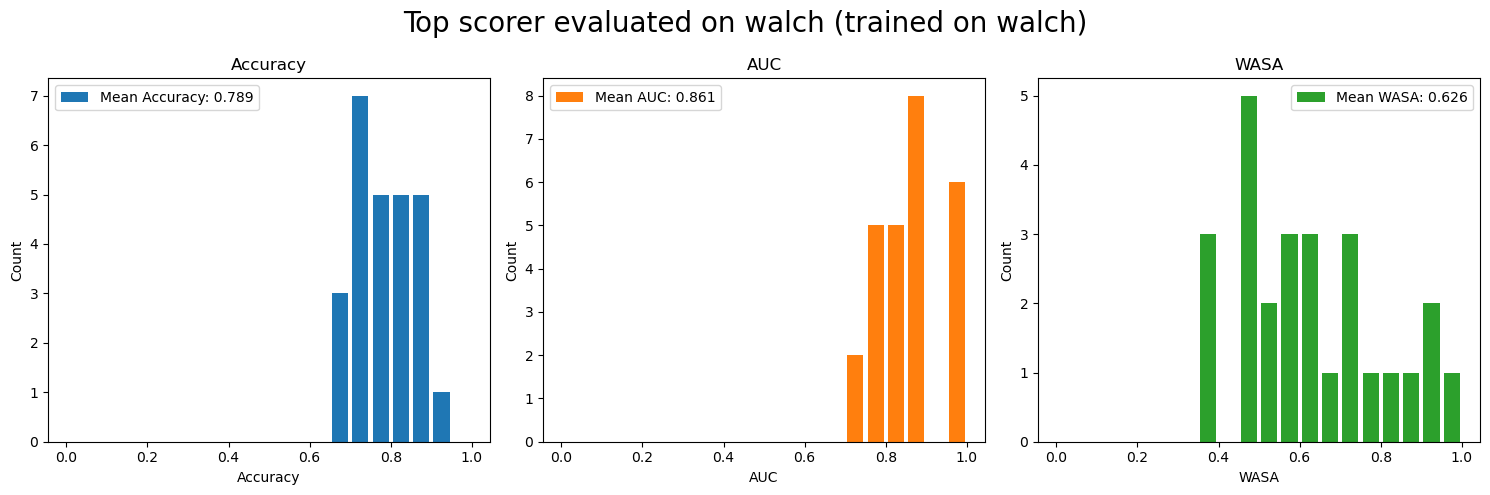

In [21]:
# Plot metrics
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

metrics_dimensions = {'sw_accuracy': 'Accuracy', 'auc': 'AUC', 'wasa': 'WASA'}
metric_colors = {'sw_accuracy': 'tab:blue', 'auc': 'tab:orange', 'wasa': 'tab:green'}

for metric, ax in zip(metrics_dimensions.keys(), axs):
    ax.hist(metrics[metric], range=(0, 1), bins=20, rwidth=0.8,
            label=f"Mean {metrics_dimensions[metric]}: {np.mean(metrics[metric]):.3f}",
            color=metric_colors[metric])
    ax.set_title(metrics_dimensions[metric])
    ax.set_xlabel(metrics_dimensions[metric])
    ax.set_ylabel('Count')
    ax.legend()

plt.suptitle('Top scorer evaluated on walch (trained on walch)',
             fontsize=20)
plt.tight_layout()
plt.show()